In [1]:
import numpy as np
import xarray as xr
import os
from matplotlib import pyplot as plt, dates
from datetime import datetime, timedelta
from scipy import signal, fft
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 12

***

### Load timeseries

In [3]:
path = '/ocean/bmoorema/research/MEOPAR/analysis-ben/data'
subdomain, skip = [110, 370, 300, 850], 5
loc = (0, 0, slice(*subdomain[2:], skip), slice(*subdomain[:2], skip))
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
tmask = mask.tmask[loc].values.ravel().astype(bool)
gridx, gridy = [var.ravel()[tmask] for var in np.meshgrid(mask.x[loc[3]], mask.y[loc[2]])]
stations = {
    'Discovery Passage': (730, 125),
    'Texada': (637, 175),
    'Central VI': (546, 174),
    'Boundary Pass': (370, 300),
}
cutoffs = {
    2015: [(4, 12), (8, 24)],
    2016: [(4,  7), (8, 22)],
    2017: [(4, 27), (9,  4)],
    2018: [(4,  5), (9,  2)],
    2019: [(4,  2), (9,  6)],
}
theta = np.deg2rad(55.5)

In [4]:
data = {'votemper': {}, 'nitrate': {}}

# Load HRDPS
with xr.open_dataset(path + '/HRDPS_1h_20141201_20200201_wind.nc') as ds:

    # Meshmask cut everything but open SoG
    landmask = ds.landmask.values
    landmask[:25, :] = 0   # San Juan Islands
    landmask[100:, :] = 0  # Discovery Islands
    landmask[:40, :50] = 0 # Left corner
    landmask[:40, 73:] = 0 # JdF/Gulf Islands
    landmask[40:, 61:] = 0 # Fraser River
    landmask[58:, 53:] = 0 # Howe Sound
    landmask[76:, 35:] = 0 # Jervis Inlet
    landmask = landmask.ravel().astype('bool')

    # Alongaxis wind
    u, v = [ds[var].values.reshape(-1, len(landmask))[:, landmask] for var in ['u_wind', 'v_wind']]
    v = v * np.cos(theta) - u * np.sin(theta)
    data['wspd'] = v.mean(axis=1)

# Load SalishSeaCast
slc = slice(None, None, skip)
with xr.open_dataset(path + '/SalishSea_1h_20141201_20200201_grid_T.nc') as ds:
    data['time'] = ds.time_counter.values.astype('datetime64[s]').astype(datetime)
    for var in tqdm(['votemper', 'nitrate']):
        data[var]['full'] = ds[var].isel(y=slc, x=slc).values.reshape(-1, len(tmask))[:, tmask]
        for station in stations:
            j, i = stations[station]
            data[var][station] = ds[var].isel(y=j-subdomain[2], x=i-subdomain[0]).values

  0%|          | 0/2 [00:00<?, ?it/s]

***

### Plot timeseries

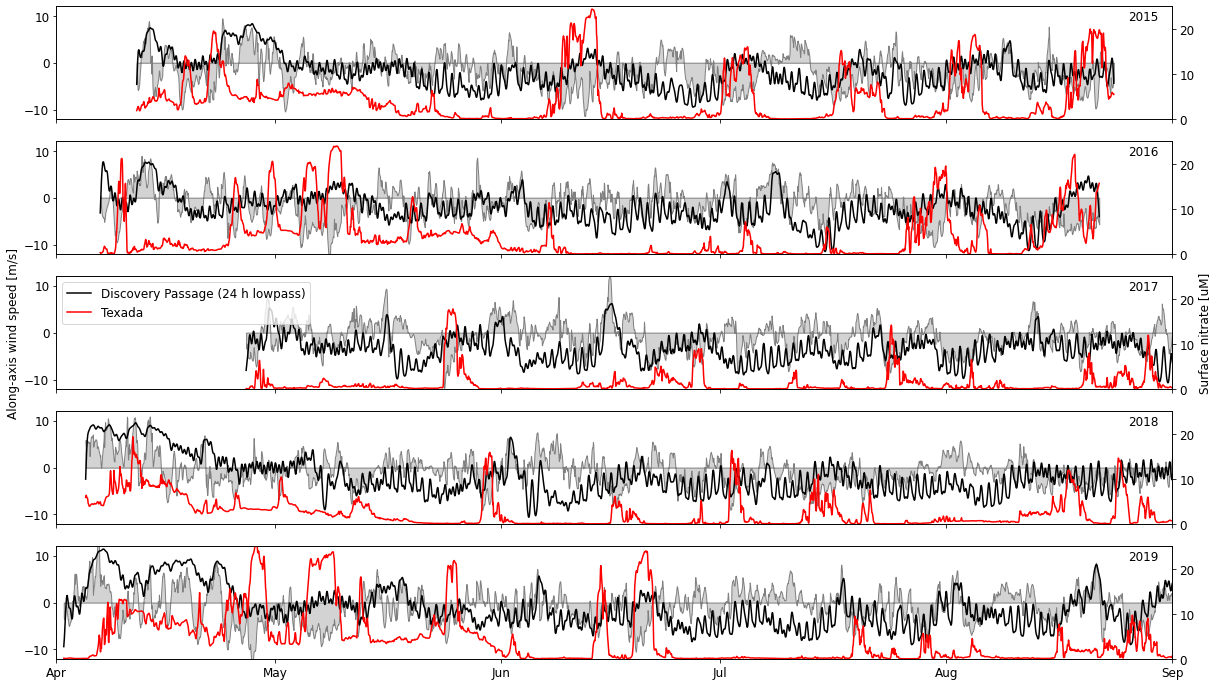

In [5]:
# Make plot area
index = []
fig, axs = plt.subplots(5, 1, figsize=(20, 12))
window = signal.get_window('blackman', 24)
for ax, year in zip(axs, range(2015, 2020)):
    
    # Determine time index
    bounds = [datetime(year, *md) for md in cutoffs[year]]
    index.append(np.logical_and(data['time'] > bounds[0], data['time'] < bounds[1]))
    
    # Plot wind speed
    ax.fill_between(data['time'][index[-1]], data['wspd'][index[-1]], fc='lightgray', ec='gray')
    
    # Plot nitrate
    ax2 = ax.twinx()
    for station, color in zip(['Discovery Passage', 'Texada'], ['k', 'r']):
        y, label = data['nitrate'][station][index[-1]], station
        if station == 'Discovery Passage':
            y = signal.convolve(y, window / sum(window), mode='same')
            label = label + ' (24 h lowpass)'
        ax2.plot(data['time'][index[-1]], y, '-', color=color, label=label)
    
    # Formatting
    ax.set_xlim([datetime(year, 4, 1), datetime(year, 9, 1)])
    ax.set_ylim([-12, 12])
    ax2.set_ylim([0, 25])
    ax.xaxis.set_major_locator(dates.MonthLocator())
    ax.xaxis.set_major_formatter(dates.DateFormatter('%b'))
    ax.text(0.96, 0.88, f'{year}', transform=ax.transAxes)
    if year < 2019: ax.xaxis.set_ticklabels('')
    if year == 2017:
        ax.set_ylabel('Along-axis wind speed [m/s]')
        ax2.set_ylabel('Surface nitrate [uM]')
        ax2.legend(loc=2)

***

### Spectral analysis

Zero padding

In [6]:
# Zero padding
record = {key: [] for key in ['wspd', 'Texada', 'Discovery Passage']}
rng = np.random.default_rng(seed=8000)
for i in index:
    zeros = np.zeros(rng.integers(low=5000, high=10000))
    record['wspd'].extend([data['wspd'][i], zeros])
    for station in ('Texada', 'Discovery Passage'):
        record[station].extend([data['nitrate'][station][i], zeros])
for key in record:
    record[key] = np.hstack(record[key])

In [7]:
# Global fft parameters
n, fs = len(record['wspd']), 24
nfft = 2**int(np.ceil(np.log2(n)))
freq = np.linspace(0, int(fs/2), int(nfft/2+1))

#### Example
$p=10$ (bandwidth = 0.023 d$^{-1}$) and $n$ tapers = 20

Text(0, 0.5, 'C$_{xy}$')

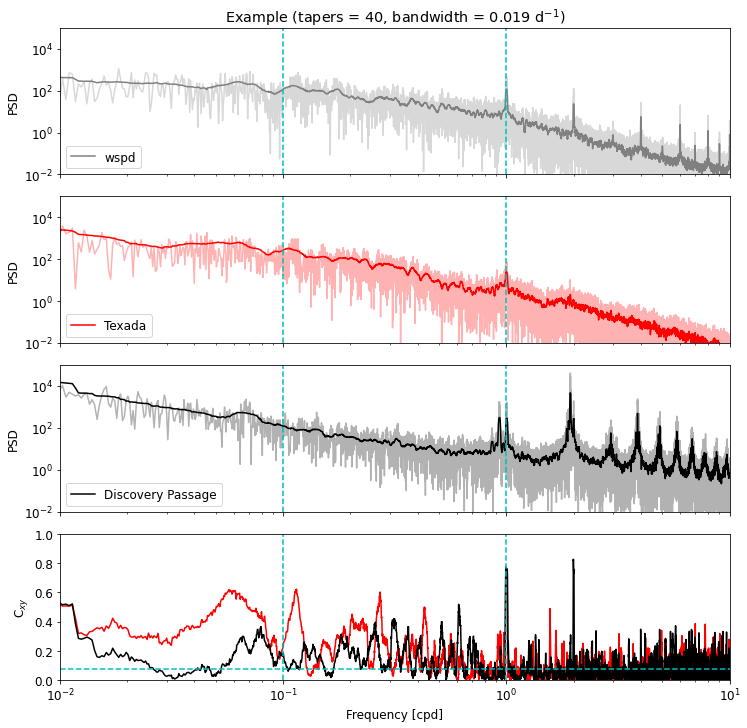

In [8]:
# Example for normalized bandwidth p=10
p = 20
k = int(2 * p)
taper = signal.windows.dpss(n, 1, 1)[0, :]
tapers, weights = signal.windows.dpss(n, p, k, return_ratios=True)
fft_single, fft_multi = {}, {}
for key in record:
    fft_single[key] = np.fft.rfft(taper * (record[key] - record[key].mean()), nfft)
    fft_multi[key] = np.fft.rfft(tapers * (record[key] - record[key].mean()), nfft)

# Make figure area
fig, axs = plt.subplots(4, 1, figsize=(12, 12), gridspec_kw={'hspace': 0.15})
axs[0].set_title(f'Example (tapers = {k}, bandwidth = {2*p*fs/n:.03f} d$^{{-1}}$)')
for ax, key, color in zip(axs, ['wspd', 'Texada', 'Discovery Passage'], ['gray', 'r', 'k']):
    
    # Plot fft for single and multi-tapers
    ax.plot(freq, abs(fft_single[key])**2, '-', color=color, alpha=0.3)
    ax.plot(freq, np.average(abs(fft_multi[key])**2, weights=weights, axis=0), '-', color=color, label=key)
    for x in [0.1, 1]: ax.plot([x, x], [1e-2, 1e5], 'c--')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([1e-2, 10])
    ax.set_ylim([1e-2, 1e5])
    ax.xaxis.set_ticklabels('')
    ax.set_ylabel('PSD')
    ax.legend(loc=3)
    
    # Calculate and plot coherence
    if key in ['Texada', 'Discovery Passage']:
        Pxx = np.sum(weights[:, None] * abs(fft_multi['wspd'])**2, axis=0)
        Pyy = np.sum(weights[:, None] * abs(fft_multi[key])**2, axis=0)
        Pxy = np.sum(weights[:, None] * fft_multi['wspd'] * np.conj(fft_multi[key]), axis=0)
        Cxy = abs(Pxy)**2 / (Pxx * Pyy)
        axs[3].plot(freq, Cxy, '-', color=color)

# Format and annotate coherence panel
ci = 1 - 0.05**(1 / (k - 1))
axs[3].plot([1e-2, 10], [ci, ci], 'c--')
for x in [0.1, 1]: axs[3].plot([x, x], [0, 1], 'c--')
axs[3].set_xscale('log')
axs[3].set_xlim([1e-2, 10])
axs[3].set_ylim([0, 1])
axs[3].set_xlabel('Frequency [cpd]')
axs[3].set_ylabel('C$_{xy}$')

***

### EOF analysis

In [9]:
def varimax(A, maxiter=40, tol=1e-5):
    """Calculate the varimax rotation matrix based on
    Horst, P. (1965) Factor Analysis of Data Matrices. Holt, Rinehart and Winston. New York, USA.
    """
    
    # Initialization
    n, p = A.shape
    H = np.eye(p)
    d = 0
    
    # Iteration
    for i in tqdm(range(maxiter)):
        d_old = d
        B = A.dot(H)  # -------------------------------------------------------- 18.4.5
        beta = B * B * B - B.dot(np.diag(np.diag(B.T.dot(B)))) / n  # ---------- 18.4.6
        P, Delta, Q_T = np.linalg.svd(A.T.dot(beta))  # ------------------------ 18.7.42
        H = P.dot(Q_T)  # ------------------------------------------------------ 18.7.45
        d = sum(Delta)
        
        # Convergence
        if d_old != 0 and d/d_old < 1 + tol: break

    return H

In [10]:
def calc_EOF(z, rotate=True):
    """Calculate EOF matrices of n x p data matrix z using SVD
    and optional varimax rotation
    """
    
    # EOF dict
    EOF = {}
    
    # Calculate orthogonal EOF matrices
    A_prime, sqrtL, E_T = np.linalg.svd(z, full_matrices=False)
    EOF['A'] = A_prime.dot(np.diag(sqrtL))
    A2 = EOF['A'] * EOF['A']
    EOF['var'] = A2.sum(axis=0) / A2.sum()
    EOF['E'] = E_T.T
    
    # Calculate rotated matrices
    if rotate:

        # Get varimax rotation matrix
        R = varimax(EOF['A'])

        # Rotate matrices
        EOF['B'] = EOF['A'].dot(R)
        B2 = EOF['B'] * EOF['B']
        EOF['var_rot'] = B2.sum(axis=0) / B2.sum()
        EOF['U'] = EOF['E'].dot(R)
        
        # Sort rotated matrices
        isort = EOF['var_rot'].argsort()[::-1]
        EOF['var_rot'] = EOF['var_rot'][isort]
        EOF['B'] = EOF['B'][:, isort]
        EOF['U'] = EOF['U'][:, isort]
    
    return EOF

In [11]:
# Filter dataset
index_full = np.array(index).sum(axis=0).astype(bool)
window = np.blackman(1235)
filtered = []
for col in tqdm(data['nitrate']['full'].T):
    filtered.append(col - np.convolve(col, window / sum(window), mode='same'))
filtered = np.vstack(filtered).T
z = filtered[index_full, :]

# Calc EOFs
EOF = calc_EOF(z - z.mean(axis=0))

  0%|          | 0/2002 [00:00<?, ?it/s]

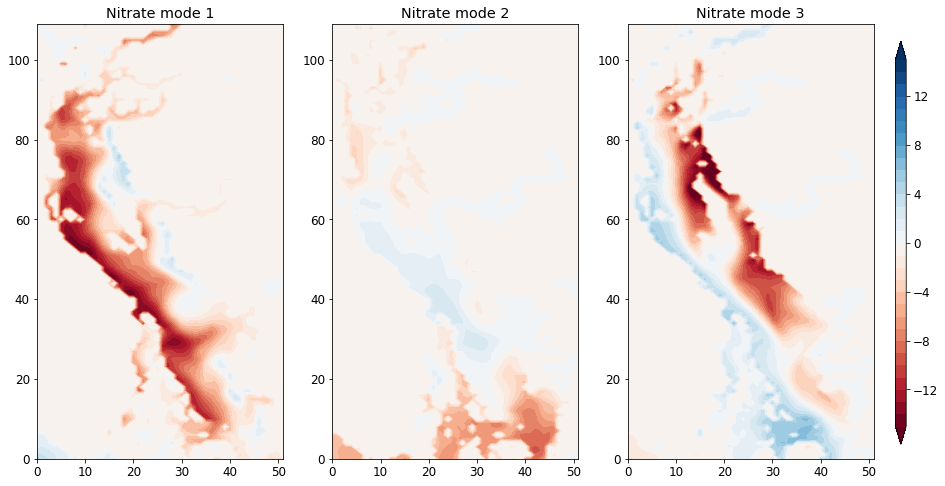

In [73]:
# Plot fields
fig, axs = plt.subplots(1, 3, figsize=(15, 8))

for ax, mode in zip(axs, range(3)):
    
    norm = -np.percentile(abs(EOF['B'][:, mode]), 99.9)
    gridded = np.zeros(mask.nav_lon.shape)
    for y, x, val in zip(gridy, gridx, EOF['U'][:, mode]):
        gridded[y, x] = val
    gridded = gridded[loc[2:]]
    c = ax.contourf(gridded * norm, levels=np.arange(-15, 15.1, 1), cmap='RdBu', extend='both')
    ax.set_title(f'Nitrate mode {mode+1}')

cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(c, cax=cax)

In [68]:
# Global fft parameters
n, fs = len(EOF['B'][:, 0]), 24
nfft = 2**int(np.ceil(np.log2(n)))
freq = np.linspace(0, int(fs/2), int(nfft/2+1))

Text(0, 0.5, 'C$_{xy}$')

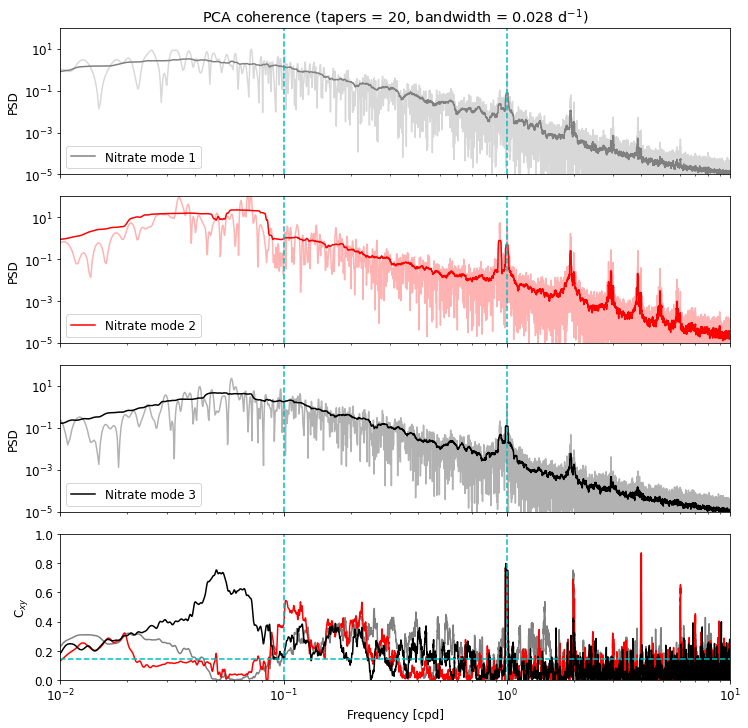

In [83]:
# Example for normalized bandwidth p=10
p = 10
k = int(2 * p)
taper = signal.windows.dpss(n, 1, 1)[0, :]
tapers, weights = signal.windows.dpss(n, p, k, return_ratios=True)
fft_single, fft_multi = {}, {}
wspd2 = data['wspd'][index_full] # * abs(data['wspd'][index_full])
fft_wind = np.fft.rfft(tapers * (wspd2 - wspd2.mean()), nfft)
for mode in range(3):
    norm = -np.percentile(abs(EOF['B'][:, mode]), 99.9)
    fft_single[mode] = np.fft.rfft(taper / norm * (EOF['B'][:, mode] - EOF['B'][:, mode].mean()), nfft)
    fft_multi[mode] = np.fft.rfft(tapers / norm * (EOF['B'][:, mode] - EOF['B'][:, mode].mean()), nfft)
Pxx = np.sum(weights[:, None] * abs(fft_wind)**2, axis=0)

# Make figure area
fig, axs = plt.subplots(4, 1, figsize=(12, 12), gridspec_kw={'hspace': 0.15})
axs[0].set_title(f'PCA coherence (tapers = {k}, bandwidth = {2*p*fs/n:.03f} d$^{{-1}}$)')
for ax, mode, color in zip(axs, range(3), ['gray', 'r', 'k']):
    
    # Plot fft for single and multi-tapers
    ax.plot(freq, abs(fft_single[mode])**2, '-', color=color, alpha=0.3)
    ax.plot(freq, np.average(abs(fft_multi[mode])**2, weights=weights, axis=0), '-', color=color, label=f'Nitrate mode {mode+1}')
    for x in [0.1, 1]: ax.plot([x, x], [1e-5, 1e2], 'c--')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([1e-2, 10])
    ax.set_ylim([1e-5, 1e2])
    ax.xaxis.set_ticklabels('')
    ax.set_ylabel('PSD')
    ax.legend(loc=3)
    
    # Calculate and plot coherence
    Pyy = np.sum(weights[:, None] * abs(fft_multi[mode])**2, axis=0)
    Pxy = np.sum(weights[:, None] * fft_wind * np.conj(fft_multi[mode]), axis=0)
    Cxy = abs(Pxy)**2 / (Pxx * Pyy)
    axs[3].plot(freq, Cxy, '-', color=color)

# Format and annotate coherence panel
ci = 1 - 0.05**(1 / (k - 1))
axs[3].plot([1e-2, 10], [ci, ci], 'c--')
for x in [0.1, 1]: axs[3].plot([x, x], [0, 1], 'c--')
axs[3].set_xscale('log')
axs[3].set_xlim([1e-2, 10])
axs[3].set_ylim([0, 1])
axs[3].set_xlabel('Frequency [cpd]')
axs[3].set_ylabel('C$_{xy}$')